In [35]:
import json
import os

import corner
import emcee
import numpy as np
from astropy.io import fits, ascii
from matplotlib import pyplot as plt
from scipy.optimize import minimize

import sys
sys.path.append('../core/')

from inner_disk_models import elliptical_ring
from sce_adjusted import sceua
from disk_fitting import get_theta0, func_cps, log_like, log_prior, log_prob

In [36]:
# target
t = 'HD_100453'

# Path to data (OI FITS file)
path = '../../data/'
path_load = f"../../data/HD_100453/GRAVITY/SCI_HD100453_GRAVITY_MED_singlescivis_0000_singlesciviscalibrated_0000.fits"

# Path to database where results are stored
path_working_place = '../../workplace/inner_disk_models/mcmc_fitting/'

In [37]:
# load f_c and k_s values
disk_contribution_f_c = ascii.read(os.path.join(path, 'sample_properties', 'circumstellar_contribution_f_c.dat'))
spectral_indices_k_s = ascii.read(os.path.join(path, 'sample_properties', 'spectral_indices_k_s.dat'))

In [38]:
fit_modes = [
    'unconstrained',
    # 'modulation_amplitude',
    # 'f_lor',
    # 'f_lor_modulation_amplitude',
]

In [39]:
# ---- interferometric parameters
n_baselines = 6
n_triplets = 4

# ---- exposure time bins [h]
exptime_bin = 0.5

# ---- spectral binning of SC data
spectral_bins = 5

# ---- central wavelength that is used as lam0
lam0 = 2.25e-6

In [40]:
# ---- SCE parameters (current numbers for test purposes, choose larger numbers for actual simulations)
maxn = int(1e6) # int(1e6)
kstop = 30 # 50
pcento = 0.001
peps = 0.001
iseed = 0
iniflg = 1
ngs = 5 # 50

# ---- MCMC parameters (current numbers for test purposes, choose larger numbers for actual simulations)
nwalkers = 100 # 200
nsteps = 2000 # 10000

In [41]:
# minimum errors of visibilities and CPs
e_min_vis2 = 0.02
e_min_cp = 1.

# for visibility plots
vv, uu = np.mgrid[-150:151, -150:151]

# minimum wavelength (shorter wavelengths are affected by metrology lasers)
lambda_min = 2.03e-6

In [42]:
# define prior ranges
theta_ranges = np.array([
    (-6., 0.),
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (-2., 2.),
    (-3., 3.),
    (0., 1.),
    (-2. * np.pi, 2 * np.pi),
    (-1., 1.),
    (-1., 1.)
])

# labels for plotting
labels = np.array([r'$k_\mathrm{c}$',
                   r'$f_\mathrm{c}$',
                   r'$f_\mathrm{h}$',
                   r'$f_\mathrm{Lor}$',
                   r'$l_\mathrm{a}$',
                   r'$l_\mathrm{kr}$',
                   r'$\cos i$',
                   r'$\theta$',
                   r'$c_1$',
                   r'$s_1$', ])

In [43]:
for fit_mode in fit_modes:

    theta_0, indices = get_theta0(fit_mode)

    # dimensionality of the problem
    ndim = len(theta_0.compressed())
    
    # define k_s
    index_k_s = spectral_indices_k_s['NAME'].data == t
    k_s = spectral_indices_k_s['k_s'].data[index_k_s][0]

    # get f_c starting value
    index_f_c = disk_contribution_f_c['NAME'].data == t
    f_c_0 = disk_contribution_f_c['f_c'].data[index_f_c][0]
    e_f_c_0 = np.average([f_c_0 - disk_contribution_f_c['f_c_lo'].data[index_f_c],
                          disk_contribution_f_c['f_c_hi'].data[index_f_c] - f_c_0])
    theta_0.data[1] = f_c_0

In [44]:
    hdu = fits.open(os.path.join(path_load))

In [45]:
    # get target name
    tmp_target = hdu[0].header['HIERARCH ESO FT ROBJ NAME']

    # get number of exposures and corresponding uv_bins
    n_exp = int(len(hdu[10].data['UCOORD']) / n_baselines)

    # get duration of the observation
    obs_time = (np.max(hdu[10].data['MJD']) - np.min(hdu[10].data['MJD'])) * 24
    print(f'Total integration time: {obs_time} h')

Total integration time: 0.20083333365619183 h


In [46]:
    # bin down to 1 data point per half hour of observation
    if obs_time / exptime_bin < 1:
        n_bin_exp = n_exp
    else:
        n_bin_exp = int(np.ceil(n_exp / (obs_time / exptime_bin)))
    print(f'Number of binned exposures: {n_bin_exp}')

Number of binned exposures: 2


In [47]:
    # get number of UV bins
    n_uv_bins = int(np.ceil(n_exp / n_bin_exp))

In [48]:
    # UT names and indices
    index_to_ut = dict.fromkeys(hdu[1].data['STA_INDEX'])
    for i, tmp_index in enumerate(hdu[1].data['STA_INDEX']):
        index_to_ut[tmp_index] = hdu[1].data['STA_NAME'][i]

    # get u and v coordinates for SC
    u_coord_sc = hdu[10].data['UCOORD']
    v_coord_sc = hdu[10].data['VCOORD']
    baselines_sc = hdu[10].data['STA_INDEX']
    u1_coord_sc = hdu[11].data['U1COORD']
    v1_coord_sc = hdu[11].data['V1COORD']
    u2_coord_sc = hdu[11].data['U2COORD']
    v2_coord_sc = hdu[11].data['V2COORD']
    u3_coord_sc = - (u1_coord_sc + u2_coord_sc)
    v3_coord_sc = - (v1_coord_sc + v2_coord_sc)
    triplets_sc = hdu[11].data['STA_INDEX']

In [49]:
    # get SC wavelengths
    wavelengths_sc = hdu[3].data['EFF_WAVE']

    # get SC visibilities
    vis2_sc_flag = np.invert(hdu[10].data['FLAG'])
    vis2_sc = hdu[10].data['VIS2DATA']
    e_vis2_sc = hdu[10].data['VIS2ERR']

    # set VIS2 flag to false for obviously wrong values
    vis2_sc_flag[vis2_sc <= 1e-10] = False
    vis2_sc_flag[e_vis2_sc <= 1e-10] = False

In [50]:
    # get SC closure phases
    cp_sc_flag = np.invert(hdu[11].data['FLAG'])
    cp_sc = hdu[11].data['T3PHI']
    e_cp_sc = hdu[11].data['T3PHIERR']

    # set CP flag to false for obviously wrong values
    cp_sc_flag[np.abs(cp_sc) <= 1e-10] = False
    cp_sc_flag[np.abs(e_cp_sc) <= 1e-10] = False

    # get flags for coordinates
    vis2_coord_sc_flag = np.max(vis2_sc_flag, axis=1)
    cp_coord_sc_flag = np.max(cp_sc_flag, axis=1)

In [51]:
    # ---- average exposures of SC data
    if n_bin_exp == 1:
        # --- VIS2
        vis2_sc_avg_exp = vis2_sc.copy()
        e_vis2_sc_avg_exp = e_vis2_sc.copy()
        vis2_sc_flag_avg_exp = vis2_sc_flag.copy()
        u_coord_sc_avg_exp = u_coord_sc.copy()
        v_coord_sc_avg_exp = v_coord_sc.copy()
        vis2_coord_sc_flag_avg_exp = vis2_coord_sc_flag.copy()

        # --- CPs
        cp_sc_avg_exp = cp_sc.copy()
        e_cp_sc_avg_exp = e_cp_sc.copy()
        cp_sc_flag_avg_exp = cp_sc_flag.copy()
        u1_coord_sc_avg_exp = u1_coord_sc.copy()
        v1_coord_sc_avg_exp = v1_coord_sc.copy()
        u2_coord_sc_avg_exp = u2_coord_sc.copy()
        v2_coord_sc_avg_exp = v2_coord_sc.copy()
        u3_coord_sc_avg_exp = u3_coord_sc.copy()
        v3_coord_sc_avg_exp = v3_coord_sc.copy()
        cp_coord_sc_flag_avg_exp = cp_coord_sc_flag.copy()
    else:
        # --- VIS2
        vis2_sc_avg_exp = np.zeros((n_baselines * n_uv_bins, len(wavelengths_sc)))
        e_vis2_sc_avg_exp = np.zeros((n_baselines * n_uv_bins, len(wavelengths_sc)))
        vis2_sc_flag_avg_exp = np.zeros((n_baselines * n_uv_bins, len(wavelengths_sc)), dtype=bool)
        u_coord_sc_avg_exp = np.zeros((n_baselines * n_uv_bins))
        v_coord_sc_avg_exp = np.zeros((n_baselines * n_uv_bins))
        vis2_coord_sc_flag_avg_exp = np.zeros((n_baselines * n_uv_bins), dtype=bool)

        for m in range(n_uv_bins):
            for l in range(n_baselines):
                tmp_vis2_sc = vis2_sc.copy()
                tmp_e_vis2_sc = e_vis2_sc.copy()
                tmp_u_coord_sc = u_coord_sc.copy()
                tmp_v_coord_sc = v_coord_sc.copy()

                tmp_vis2_sc[np.invert(vis2_sc_flag)] = np.nan
                tmp_e_vis2_sc[np.invert(vis2_sc_flag)] = np.nan
                tmp_u_coord_sc[np.invert(vis2_coord_sc_flag)] = np.nan
                tmp_v_coord_sc[np.invert(vis2_coord_sc_flag)] = np.nan

                tmp_weights_avg_exp = (1 / (
                tmp_e_vis2_sc[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines,
                :])) ** 2

                tmp_vis2_avg_exp = np.nansum(tmp_weights_avg_exp * tmp_vis2_sc[
                                                                   l + n_baselines * m * n_bin_exp:l + n_baselines * (
                                                                               m + 1) * n_bin_exp:n_baselines],
                                             axis=0) / np.nansum(tmp_weights_avg_exp, axis=0)
                tmp_e_vis2_avg_exp = np.sqrt((np.nansum(tmp_weights_avg_exp * tmp_vis2_sc[
                                                                              l + n_baselines * m * n_bin_exp:l + n_baselines * (
                                                                                          m + 1) * n_bin_exp:n_baselines] ** 2,
                                                        axis=0) /
                                              np.nansum(tmp_weights_avg_exp, axis=0) - (
                                                  tmp_vis2_avg_exp) ** 2) / np.array(
                    [len(tmp_w[np.invert(np.isnan(tmp_w))]) - 1 for tmp_w in tmp_weights_avg_exp.T[:, ]]))

                vis2_sc_avg_exp[l + n_baselines * m,] = tmp_vis2_avg_exp
                e_vis2_sc_avg_exp[l + n_baselines * m,] = tmp_e_vis2_avg_exp
                vis2_sc_flag_avg_exp[l + n_baselines * m,] = np.invert(
                    np.isinf(tmp_e_vis2_avg_exp)) & np.invert(np.isnan(tmp_e_vis2_avg_exp)) & np.max(
                    vis2_sc_flag[
                    l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines, ],
                    axis=0)

                u_coord_sc_avg_exp[l + n_baselines * m] = np.nanmean(tmp_u_coord_sc[
                                                                     l + n_baselines * m * n_bin_exp:l + n_baselines * (
                                                                                 m + 1) * n_bin_exp:n_baselines])
                v_coord_sc_avg_exp[l + n_baselines * m] = np.nanmean(tmp_v_coord_sc[
                                                                     l + n_baselines * m * n_bin_exp:l + n_baselines * (
                                                                                 m + 1) * n_bin_exp:n_baselines])
                vis2_coord_sc_flag_avg_exp[l + n_baselines * m] = np.max(vis2_coord_sc_flag[
                                                                         l + n_baselines * m * n_bin_exp:l + n_baselines * (
                                                                                     m + 1) * n_bin_exp:n_baselines])

        # --- CPs
        cp_sc_avg_exp = np.zeros((n_triplets * n_uv_bins, len(wavelengths_sc)))
        e_cp_sc_avg_exp = np.zeros((n_triplets * n_uv_bins, len(wavelengths_sc)))
        cp_sc_flag_avg_exp = np.zeros((n_triplets * n_uv_bins, len(wavelengths_sc)), dtype=bool)
        u1_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
        v1_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
        u2_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
        v2_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
        u3_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
        v3_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
        cp_coord_sc_flag_avg_exp = np.zeros((n_triplets * n_uv_bins), dtype=bool)

        for m in range(n_uv_bins):
            for l in range(n_triplets):
                tmp_cp_sc = cp_sc.copy()
                tmp_e_cp_sc = e_cp_sc.copy()
                tmp_u1_coord_sc = u1_coord_sc.copy()
                tmp_u2_coord_sc = u2_coord_sc.copy()
                tmp_u3_coord_sc = u3_coord_sc.copy()
                tmp_v1_coord_sc = v1_coord_sc.copy()
                tmp_v2_coord_sc = v2_coord_sc.copy()
                tmp_v3_coord_sc = v3_coord_sc.copy()

                tmp_cp_sc[np.invert(cp_sc_flag)] = np.nan
                tmp_e_cp_sc[np.invert(cp_sc_flag)] = np.nan
                tmp_u1_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
                tmp_u2_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
                tmp_u3_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
                tmp_v1_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
                tmp_v2_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
                tmp_v3_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan

                tmp_weights_avg_exp = (1 / (
                tmp_e_cp_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets,
                :])) ** 2

                tmp_cp_avg_exp = np.nansum(tmp_weights_avg_exp * tmp_cp_sc[
                                                                 l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                             m + 1) * n_bin_exp:n_triplets, :],
                                           axis=0) / np.nansum(tmp_weights_avg_exp, axis=0)
                tmp_e_cp_avg_exp = np.sqrt((np.nansum(tmp_weights_avg_exp * tmp_cp_sc[
                                                                            l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                        m + 1) * n_bin_exp:n_triplets,
                                                                            :] ** 2, axis=0) /
                                            np.nansum(tmp_weights_avg_exp, axis=0) - (
                                                tmp_cp_avg_exp) ** 2) / np.array(
                    [len(tmp_w[np.invert(np.isnan(tmp_w))]) - 1 for tmp_w in tmp_weights_avg_exp.T[:, ]]))

                cp_sc_avg_exp[l + n_triplets * m,] = tmp_cp_avg_exp
                e_cp_sc_avg_exp[l + n_triplets * m,] = tmp_e_cp_avg_exp
                cp_sc_flag_avg_exp[l + n_triplets * m,] = np.invert(np.isinf(tmp_e_cp_avg_exp)) & np.invert(
                    np.isnan(tmp_e_cp_avg_exp)) & np.max(cp_sc_flag[
                                                         l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                     m + 1) * n_bin_exp:n_triplets, ], axis=0)

                u1_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_u1_coord_sc[
                                                                     l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                 m + 1) * n_bin_exp:n_triplets])
                v1_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_v1_coord_sc[
                                                                     l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                 m + 1) * n_bin_exp:n_triplets])
                u2_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_u2_coord_sc[
                                                                     l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                 m + 1) * n_bin_exp:n_triplets])
                v2_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_v2_coord_sc[
                                                                     l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                 m + 1) * n_bin_exp:n_triplets])
                u3_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_u3_coord_sc[
                                                                     l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                 m + 1) * n_bin_exp:n_triplets])
                v3_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_v3_coord_sc[
                                                                     l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                 m + 1) * n_bin_exp:n_triplets])
                cp_coord_sc_flag_avg_exp[l + n_triplets * m] = np.max(cp_coord_sc_flag[
                                                                      l + n_triplets * m * n_bin_exp:l + n_triplets * (
                                                                                  m + 1) * n_bin_exp:n_triplets])

    # enhance uncertainties if they are too low
    e_vis2_sc_avg_exp[e_vis2_sc_avg_exp < e_min_vis2] = e_min_vis2
    e_cp_sc_avg_exp[e_cp_sc_avg_exp < e_min_cp] = e_min_cp

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide


In [52]:
    # ---- bin SC data
    bin_edges = np.histogram_bin_edges(wavelengths_sc, bins=spectral_bins)

    # --- VIS2
    wavelengths_sc_vis2_bin = np.zeros((n_baselines * n_uv_bins, spectral_bins))
    vis2_sc_bin = np.zeros((n_baselines * n_uv_bins, spectral_bins))
    e_vis2_sc_bin = np.zeros((n_baselines * n_uv_bins, spectral_bins))
    mask_vis2_sc_bin = np.ones((n_baselines * n_uv_bins, spectral_bins), dtype=bool)

    # average to *spectral_bins* wavelength channels
    for l, _ in enumerate(vis2_coord_sc_flag_avg_exp):

        for m in range(spectral_bins):
            # mask for current wavelength bin and minimum metrology laser wavelength
            tmp_mask = (wavelengths_sc > bin_edges[m]) & (wavelengths_sc <= bin_edges[m + 1]) & (
                    wavelengths_sc > lambda_min)

            tmp_wavelengths = wavelengths_sc[tmp_mask & vis2_sc_flag_avg_exp[l, :]]
            if len(tmp_wavelengths) < 2:
                mask_vis2_sc_bin[l, m] = False
                continue
            tmp_lam_mean = np.average(tmp_wavelengths)
            tmp_weights = (1 / (e_vis2_sc_avg_exp[l, :])[tmp_mask & vis2_sc_flag_avg_exp[l, :]]) ** 2

            tmp_vis2_mean = np.nansum(
                tmp_weights * (vis2_sc_avg_exp[l, :])[tmp_mask & vis2_sc_flag_avg_exp[l, :]]) / \
                            np.nansum(tmp_weights)

            tmp_e_vis2_mean = np.sqrt(
                (np.nansum(tmp_weights * (vis2_sc_avg_exp[l, :])[tmp_mask & vis2_sc_flag_avg_exp[l, :]] ** 2) /
                 np.nansum(tmp_weights) - (tmp_vis2_mean) ** 2) / (len(tmp_weights) - 1))

            wavelengths_sc_vis2_bin[l, m] = tmp_lam_mean
            vis2_sc_bin[l, m] = tmp_vis2_mean
            e_vis2_sc_bin[l, m] = tmp_e_vis2_mean

In [53]:
    # --- CPs
    wavelengths_sc_cp_bin = np.zeros((n_triplets * n_uv_bins, spectral_bins))
    cp_sc_bin = np.zeros((n_triplets * n_uv_bins, spectral_bins))
    e_cp_sc_bin = np.zeros((n_triplets * n_uv_bins, spectral_bins))
    mask_cp_sc_bin = np.ones((n_triplets * n_uv_bins, spectral_bins), dtype=bool)

    for l, _ in enumerate(cp_coord_sc_flag_avg_exp):

        for m in range(spectral_bins):
            # mask for current wavelength bin
            tmp_mask = (wavelengths_sc > bin_edges[m]) & (wavelengths_sc <= bin_edges[m + 1]) & (
                    wavelengths_sc > lambda_min)

            tmp_wavelengths = wavelengths_sc[tmp_mask & cp_sc_flag_avg_exp[l, :]]
            if len(tmp_wavelengths) < 2:
                mask_cp_sc_bin[l, m] = False
                continue
            tmp_lam_mean = np.average(tmp_wavelengths)
            tmp_weights = (1 / (e_cp_sc_avg_exp[l, :])[tmp_mask & cp_sc_flag_avg_exp[l, :]]) ** 2

            tmp_cp_mean = np.nansum(tmp_weights * (cp_sc_avg_exp[l, :])[tmp_mask & cp_sc_flag_avg_exp[l, :]]) / \
                          np.nansum(tmp_weights)
            tmp_e_cp_mean = np.sqrt(
                (np.nansum(tmp_weights * (cp_sc_avg_exp[l, :])[tmp_mask & cp_sc_flag_avg_exp[l, :]] ** 2) /
                 np.nansum(tmp_weights) - (tmp_cp_mean) ** 2) / (len(tmp_weights) - 1))

            wavelengths_sc_cp_bin[l, m] = tmp_lam_mean
            cp_sc_bin[l, m] = tmp_cp_mean
            e_cp_sc_bin[l, m] = tmp_e_cp_mean

In [54]:
    # enhance uncertainties if they are too low
    e_vis2_sc_bin[e_vis2_sc_bin < e_min_vis2] = e_min_vis2
    e_cp_sc_bin[e_cp_sc_bin < e_min_cp] = e_min_cp

In [55]:
    # get lam0 and k_s vectors for fit
    lam0_vis2 = np.ones(mask_vis2_sc_bin[mask_vis2_sc_bin].size) * lam0
    k_s_vis2 = np.ones(mask_vis2_sc_bin[mask_vis2_sc_bin].size) * k_s
    lam0_cp = np.ones(mask_cp_sc_bin[mask_cp_sc_bin].size) * lam0
    k_s_cp = np.ones(mask_cp_sc_bin[mask_cp_sc_bin].size) * k_s

In [56]:
    # --- fit vis2 SC (binned)
    param_vis2 = np.vstack(
        [np.hstack([np.repeat(i, len(j[j])) for i, j in zip(u_coord_sc_avg_exp, mask_vis2_sc_bin[:, ])]),
         np.hstack([np.repeat(i, len(j[j])) for i, j in zip(v_coord_sc_avg_exp, mask_vis2_sc_bin[:, ])]),
         lam0_vis2,
         wavelengths_sc_vis2_bin[mask_vis2_sc_bin].ravel(),
         k_s_vis2])

    # --- fit CPs SC (binned)
    param_cp = np.vstack(
        [np.hstack([np.repeat(i, len(j[j])) for i, j in zip(u1_coord_sc_avg_exp, mask_cp_sc_bin[:, ])]),
         np.hstack([np.repeat(i, len(j[j])) for i, j in zip(u2_coord_sc_avg_exp, mask_cp_sc_bin[:, ])]),
         np.hstack([np.repeat(i, len(j[j])) for i, j in zip(v1_coord_sc_avg_exp, mask_cp_sc_bin[:, ])]),
         np.hstack([np.repeat(i, len(j[j])) for i, j in zip(v2_coord_sc_avg_exp, mask_cp_sc_bin[:, ])]),
         lam0_cp,
         wavelengths_sc_cp_bin[mask_cp_sc_bin].ravel(),
         k_s_cp])

In [57]:
    # create working place directory if it does not exist
    if not os.path.isdir(os.path.join(path_working_place, t, fit_mode)):
        print(f'Creating direcotry: {os.path.join(path_working_place, t, fit_mode)}')
        os.makedirs(os.path.join(path_working_place, t, fit_mode))

Creating direcotry: ../../workplace/inner_disk_models/mcmc_fitting/HD_100453/unconstrained


Solution maximum likelihood: [-5.30881628e+00  7.52970517e-01  9.20568582e-03  9.97800031e-01
  4.78783323e-01  3.68438270e-03  6.53336330e-01  1.39705893e+00
 -7.51921810e-02 -4.38035932e-02]


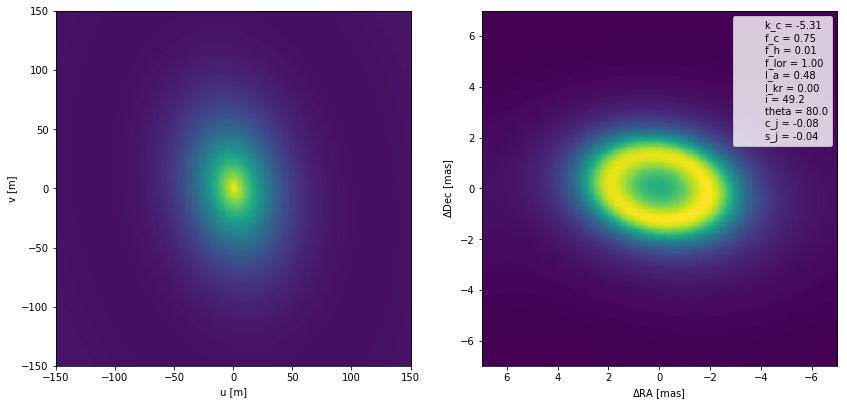

Chi2 maximum likelihood (full): 16.720783355692298
Reduced Chi2 maximum likelihood  (full): 0.4180195838923074
Chi2 maximum likelihood (VIS2): 1.4794498365426663
Reduced Chi2 maximum likelihood  (VIS2): 0.07397249182713331
Chi2 maximum likelihood (CPs): 15.241333519149633
Reduced Chi2 maximum likelihood  (CPs): 1.5241333519149634


In [58]:
    ###################################
    # 1) maximum likelihood estimator
    ###################################
    nll = lambda *args: -log_like(*args)
    soln_mle = minimize(fun=nll,
                        x0=theta_0.compressed(),
                        method='SLSQP',
                        args=(func_cps,
                              np.hstack(
                                  [vis2_sc_bin[mask_vis2_sc_bin].ravel(), cp_sc_bin[mask_cp_sc_bin].ravel()]),
                              np.hstack([e_vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                         e_cp_sc_bin[mask_cp_sc_bin].ravel()]),
                              theta_0,
                              param_vis2,
                              param_cp,
                              f_c_0,
                              e_f_c_0),
                        bounds=theta_ranges[np.invert(theta_0.mask)])

    print(f'Solution maximum likelihood: {soln_mle.x}')

    solution_parameters_mle = np.zeros(len(theta_0))
    tmp_count = 0
    for i, tmp_mask in enumerate(theta_0.mask):
        if not tmp_mask:
            solution_parameters_mle[i] = soln_mle.x[tmp_count]
            tmp_count += 1
        else:
            solution_parameters_mle[i] = theta_0.data[i]

    best_fit_model_mle = elliptical_ring(*solution_parameters_mle)
    best_fit_model_mle.plot_model(uu,
                                  vv,
                                  lam0_vis2[0],
                                  lam0_vis2[0],
                                  k_s_vis2[0],
                                  path_save=None)

    chi2_mle_full = np.sum((np.hstack([np.abs(best_fit_model_mle.get_full_visibility(*param_vis2)) ** 2,
                                       best_fit_model_mle.get_closure_phase(*param_cp)]) -
                            np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                       cp_sc_bin[mask_cp_sc_bin].ravel()])) ** 2 / np.hstack(
        [e_vis2_sc_bin[mask_vis2_sc_bin].ravel(), e_cp_sc_bin[mask_cp_sc_bin].ravel()]) ** 2)
    red_chi2_mle_full = chi2_mle_full / (
                len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) + len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)
    chi2_mle_vis2 = np.sum((np.abs(best_fit_model_mle.get_full_visibility(*param_vis2)) ** 2 -
                            vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2 / (
                               e_vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2)
    red_chi2_mle_vis2 = chi2_mle_vis2 / (len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) - ndim)
    chi2_mle_cps = np.sum((best_fit_model_mle.get_closure_phase(*param_cp) -
                           cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2 / (e_cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2)
    red_chi2_mle_cps = chi2_mle_cps / (
            len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)
    print(f'Chi2 maximum likelihood (full): {chi2_mle_full}')
    print(f'Reduced Chi2 maximum likelihood  (full): {red_chi2_mle_full}')
    print(f'Chi2 maximum likelihood (VIS2): {chi2_mle_vis2}')
    print(f'Reduced Chi2 maximum likelihood  (VIS2): {red_chi2_mle_vis2}')
    print(f'Chi2 maximum likelihood (CPs): {chi2_mle_cps}')
    print(f'Reduced Chi2 maximum likelihood  (CPs): {red_chi2_mle_cps}')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


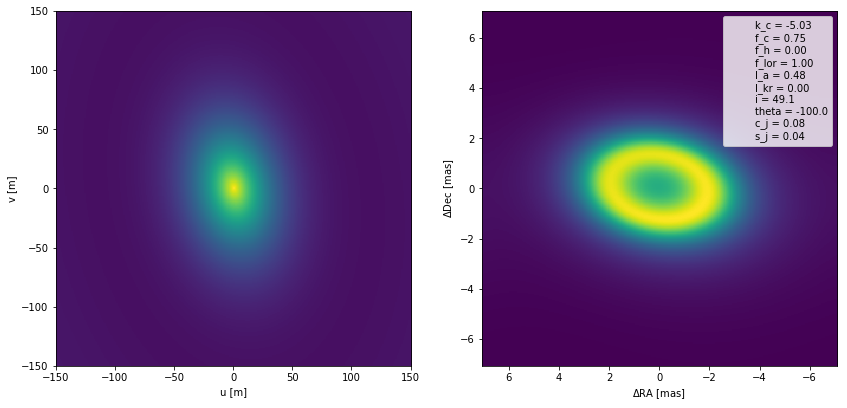

Chi2 SCE 1 (full): 16.751630067252812
Reduced Chi2 SCE 1 (full): 0.4187907516813203
Chi2 SCE 1 (VIS2): 1.4676461152896
Reduced Chi2 SCE 1 (VIS2): 0.07338230576448
Chi2 SCE 1 (CPs): 15.28398395196321
Reduced Chi2 SCE 1 (CPs): 1.528398395196321
1
3.227064247309891
1
1.2362841077989803


In [59]:
    ###################################
    # 2.1) Shuffled complex evolution
    ###################################

    x_sce_1, _, _, _, _ = sceua(func=lambda x: -log_like(x,
                                                         func=func_cps,
                                                         y=np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                                                      cp_sc_bin[mask_cp_sc_bin].ravel()]),
                                                         y_err=np.hstack(
                                                             [e_vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                                              e_cp_sc_bin[mask_cp_sc_bin].ravel()]),
                                                         masked_params=theta_0,
                                                         x_vis2=param_vis2,
                                                         x_cp=param_cp,
                                                         f_d=f_c_0,
                                                         e_f_d=e_f_c_0),
                                x0=theta_0.compressed(),
                                bl=np.array([i[0] for i in theta_ranges[np.invert(theta_0.mask)]]),
                                bu=np.array([i[1] for i in theta_ranges[np.invert(theta_0.mask)]]),
                                maxn=maxn,
                                kstop=kstop,
                                pcento=pcento,
                                peps=peps,
                                ngs=ngs,
                                iseed=iseed,
                                iniflg=iniflg,
                                testcase=False,
                                testnr=None)

    print(f'Solution SCE: {x_sce_1}')
    solution_parameters_sce_1 = np.zeros(len(theta_0))
    tmp_count = 0
    for i, tmp_mask in enumerate(theta_0.mask):
        if not tmp_mask:
            solution_parameters_sce_1[i] = x_sce_1[tmp_count]
            tmp_count += 1
        else:
            solution_parameters_sce_1[i] = theta_0.data[i]

    best_fit_model_sce_1 = elliptical_ring(*solution_parameters_sce_1)
    best_fit_model_sce_1.plot_model(uu,
                                    vv,
                                    lam0_vis2[0],
                                    lam0_vis2[0],
                                    k_s_vis2[0],
                                    path_save=None)

    chi2_sce_1_full = np.sum((np.hstack(
        [np.abs(best_fit_model_sce_1.get_full_visibility(*param_vis2)) ** 2,
         best_fit_model_sce_1.get_closure_phase(*param_cp)]) -
                              np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                         cp_sc_bin[mask_cp_sc_bin].ravel()])) ** 2 / np.hstack(
        [e_vis2_sc_bin[mask_vis2_sc_bin].ravel(), e_cp_sc_bin[mask_cp_sc_bin].ravel()]) ** 2)
    red_chi2_sce_1_full = chi2_sce_1_full / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) + len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)
    chi2_sce_1_vis2 = np.sum((np.abs(best_fit_model_sce_1.get_full_visibility(*param_vis2)) ** 2 -
                              vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2 / (
                                 e_vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2)
    red_chi2_sce_1_vis2 = chi2_sce_1_vis2 / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) - ndim)
    chi2_sce_1_cps = np.sum((best_fit_model_sce_1.get_closure_phase(*param_cp) -
                             cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2 / (
                                e_cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2)
    red_chi2_sce_1_cps = chi2_sce_1_cps / (
            len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)

    print(f'Chi2 SCE 1 (full): {chi2_sce_1_full}')
    print(f'Reduced Chi2 SCE 1 (full): {red_chi2_sce_1_full}')
    print(f'Chi2 SCE 1 (VIS2): {chi2_sce_1_vis2}')
    print(f'Reduced Chi2 SCE 1 (VIS2): {red_chi2_sce_1_vis2}')
    print(f'Chi2 SCE 1 (CPs): {chi2_sce_1_cps}')
    print(f'Reduced Chi2 SCE 1 (CPs): {red_chi2_sce_1_cps}')

    # ---- save results

    results_sce_1 = {
        'x': list(x_sce_1),
        'sol': list(solution_parameters_sce_1),
        'chi2_full': chi2_sce_1_full,
        'chi2_vis2': chi2_sce_1_vis2,
        'chi2_cps': chi2_sce_1_cps,
        'red_chi2_full': red_chi2_sce_1_full,
        'red_chi2_vis2': red_chi2_sce_1_vis2,
        'red_chi2_cps': red_chi2_sce_1_cps,
    }

    file_sce_1 = open(
        os.path.join(path_working_place, t, fit_mode, f'results_sce_1_{fit_mode}.dat'),
        "w")
    json.dump(results_sce_1, file_sce_1)
    file_sce_1.close()

    # ---- calculate and store correction factors for uncertainties
    # --- method a
    if chi2_sce_1_cps > chi2_sce_1_vis2:
        corr_factor_a_vis2 = 1
        corr_factor_a_cp = np.sqrt(chi2_sce_1_cps / chi2_sce_1_vis2)
    else:
        corr_factor_a_vis2 = np.sqrt(chi2_sce_1_vis2 / chi2_sce_1_cps)
        corr_factor_a_cp = 1

    print(corr_factor_a_vis2)
    print(corr_factor_a_cp)

    # --- method b
    corr_factor_b_vis2 = np.sqrt(red_chi2_sce_1_vis2)
    corr_factor_b_cp = np.sqrt(red_chi2_sce_1_cps)

    # do not allow values smaller than 1
    if corr_factor_b_vis2 < 1:
        corr_factor_b_vis2 = 1

    if corr_factor_b_cp < 1:
        corr_factor_b_cp = 1

    print(corr_factor_b_vis2)
    print(corr_factor_b_cp)

    # --- save correction factors
    np.savetxt(os.path.join(path_working_place, t, fit_mode,
                            f'correction_factors_chi2_{fit_mode}.dat'),
               np.array([[corr_factor_a_vis2, corr_factor_a_cp],
                         [corr_factor_b_vis2, corr_factor_b_cp]]))

In [60]:
    ###################################
    # 2a) Shuffled complex evolution
    ###################################

    x_sce_2a, _, _, _, _ = sceua(func=lambda x: -log_like(x,
                                                          func=func_cps,
                                                          y=np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                                                       cp_sc_bin[mask_cp_sc_bin].ravel()]),
                                                          y_err=np.hstack(
                                                              [e_vis2_sc_bin[
                                                                   mask_vis2_sc_bin].ravel() * corr_factor_a_vis2,
                                                               e_cp_sc_bin[
                                                                   mask_cp_sc_bin].ravel() * corr_factor_a_cp]),
                                                          masked_params=theta_0,
                                                          x_vis2=param_vis2,
                                                          x_cp=param_cp,
                                                          f_d=f_c_0,
                                                          e_f_d=e_f_c_0),
                                 x0=theta_0.compressed(),
                                 bl=np.array([i[0] for i in theta_ranges[np.invert(theta_0.mask)]]),
                                 bu=np.array([i[1] for i in theta_ranges[np.invert(theta_0.mask)]]),
                                 maxn=maxn,
                                 kstop=kstop,
                                 pcento=pcento,
                                 peps=peps,
                                 ngs=ngs,
                                 iseed=iseed,
                                 iniflg=iniflg,
                                 testcase=False,
                                 testnr=None)

    print(f'Solution SCE: {x_sce_2a}')
    solution_parameters_sce_2a = np.zeros(len(theta_0))
    tmp_count = 0
    for i, tmp_mask in enumerate(theta_0.mask):
        if not tmp_mask:
            solution_parameters_sce_2a[i] = x_sce_2a[tmp_count]
            tmp_count += 1
        else:
            solution_parameters_sce_2a[i] = theta_0.data[i]

    best_fit_model_sce_2a = elliptical_ring(*solution_parameters_sce_2a)
    best_fit_model_sce_2a.plot_model(uu,
                                     vv,
                                     lam0_vis2[0],
                                     lam0_vis2[0],
                                     k_s_vis2[0],
                                     path_save=None)

    chi2_sce_2a_full = np.sum((np.hstack(
        [np.abs(best_fit_model_sce_2a.get_full_visibility(*param_vis2)) ** 2,
         best_fit_model_sce_2a.get_closure_phase(*param_cp)]) -
                               np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                          cp_sc_bin[mask_cp_sc_bin].ravel()])) ** 2 / np.hstack(
        [e_vis2_sc_bin[mask_vis2_sc_bin].ravel() * corr_factor_a_vis2,
         e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_a_cp]) ** 2)
    red_chi2_sce_2a_full = chi2_sce_2a_full / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) + len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)
    chi2_sce_2a_vis2 = np.sum((np.abs(best_fit_model_sce_2a.get_full_visibility(*param_vis2)) ** 2 -
                               vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2 / (
                                          e_vis2_sc_bin[mask_vis2_sc_bin].ravel() * corr_factor_a_vis2) ** 2)
    red_chi2_sce_2a_vis2 = chi2_sce_2a_vis2 / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) - ndim)
    chi2_sce_2a_cps = np.sum((best_fit_model_sce_2a.get_closure_phase(*param_cp) -
                              cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2 / (
                                         e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_a_cp) ** 2)
    red_chi2_sce_2a_cps = chi2_sce_2a_cps / (
            len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)

    print(f'Chi2 SCE 2a (full): {chi2_sce_2a_full}')
    print(f'Reduced Chi2 SCE 2a (full): {red_chi2_sce_2a_full}')
    print(f'Chi2 SCE 2a (VIS2): {chi2_sce_2a_vis2}')
    print(f'Reduced Chi2 SCE 2a (VIS2): {red_chi2_sce_2a_vis2}')
    print(f'Chi2 SCE 2a (CPs): {chi2_sce_2a_cps}')
    print(f'Reduced Chi2 SCE 2a (CPs): {red_chi2_sce_2a_cps}')

    # ---- save results
    results_sce_2a = {
        'x': list(x_sce_2a),
        'sol': list(solution_parameters_sce_2a),
        'chi2_full': chi2_sce_2a_full,
        'chi2_vis2': chi2_sce_2a_vis2,
        'chi2_cps': chi2_sce_2a_cps,
        'red_chi2_full': red_chi2_sce_2a_full,
        'red_chi2_vis2': red_chi2_sce_2a_vis2,
        'red_chi2_cps': red_chi2_sce_2a_cps,
    }

    file_sce_2a = open(
        os.path.join(path_working_place, t, fit_mode, f'results_sce_2a_{fit_mode}.dat'),
        "w")
    json.dump(results_sce_2a, file_sce_2a)
    file_sce_2a.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
THE BEST POINT HAS IMPROVED IN LAST 30 LOOPS BY LESS THAN THE THRESHOLD 0.001000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 11643
NORMALIZED GEOMETRIC RANGE = 0.189496
THE BEST POINT HAS IMPROVED IN LAST 30 LOOPS BY 0.000815
Solution SCE: [-5.99999998  0.75500479  0.0340009   0.5110825   0.49165166  2.58199883
  0.61499425  1.3719218  -0.05960681 -0.03063062]


Chi2 SCE 2a (full): 12.48818222858157
Reduced Chi2 SCE 2a (full): 0.31220455571453926
Chi2 SCE 2a (VIS2): 10.869295414048608
Reduced Chi2 SCE 2a (VIS2): 0.5434647707024304
Chi2 SCE 2a (CPs): 1.61888681453296
Reduced Chi2 SCE 2a (CPs): 0.161888681453296


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


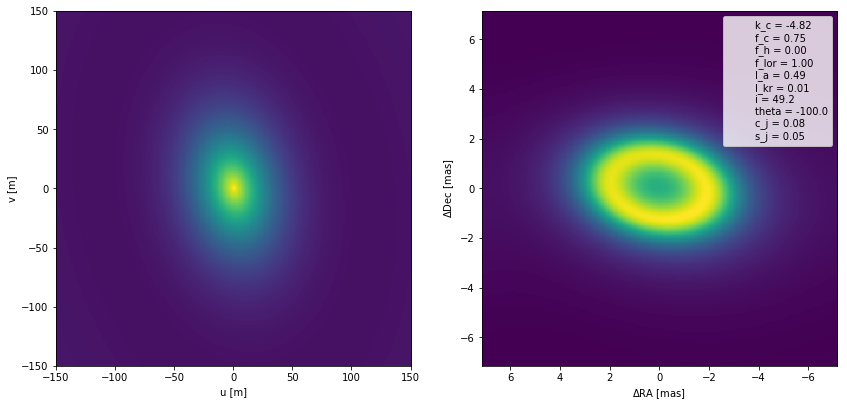

Chi2 SCE 2b (full): 11.495165579727093
Reduced Chi2 SCE 2b (full): 0.28737913949317734
Chi2 SCE 2b (VIS2): 1.428491870933205
Reduced Chi2 SCE 2b (VIS2): 0.07142459354666025
Chi2 SCE 2b (CPs): 10.066673708793887
Reduced Chi2 SCE 2b (CPs): 1.0066673708793887


In [61]:
    ###################################
    # 2b) Shuffled complex evolution 2b)
    ###################################

    x_sce_2b, _, _, _, _ = sceua(func=lambda x: -log_like(x,
                                                          func=func_cps,
                                                          y=np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                                                       cp_sc_bin[mask_cp_sc_bin].ravel()]),
                                                          y_err=np.hstack(
                                                              [e_vis2_sc_bin[
                                                                   mask_vis2_sc_bin].ravel() * corr_factor_b_vis2,
                                                               e_cp_sc_bin[
                                                                   mask_cp_sc_bin].ravel() * corr_factor_b_cp]),
                                                          masked_params=theta_0,
                                                          x_vis2=param_vis2,
                                                          x_cp=param_cp,
                                                          f_d=f_c_0,
                                                          e_f_d=e_f_c_0),
                                 x0=theta_0.compressed(),
                                 bl=np.array([i[0] for i in theta_ranges[np.invert(theta_0.mask)]]),
                                 bu=np.array([i[1] for i in theta_ranges[np.invert(theta_0.mask)]]),
                                 maxn=maxn,
                                 kstop=kstop,
                                 pcento=pcento,
                                 peps=peps,
                                 ngs=ngs,
                                 iseed=iseed,
                                 iniflg=iniflg,
                                 testcase=False,
                                 testnr=None)

    print(f'Solution SCE: {x_sce_2b}')
    solution_parameters_sce_2b = np.zeros(len(theta_0))
    tmp_count = 0
    for i, tmp_mask in enumerate(theta_0.mask):
        if not tmp_mask:
            solution_parameters_sce_2b[i] = x_sce_2b[tmp_count]
            tmp_count += 1
        else:
            solution_parameters_sce_2b[i] = theta_0.data[i]

    best_fit_model_sce_2b = elliptical_ring(*solution_parameters_sce_2b)
    best_fit_model_sce_2b.plot_model(uu,
                                     vv,
                                     lam0_vis2[0],
                                     lam0_vis2[0],
                                     k_s_vis2[0],
                                     path_save=None)

    chi2_sce_2b_full = np.sum((np.hstack(
        [np.abs(best_fit_model_sce_2b.get_full_visibility(*param_vis2)) ** 2,
         best_fit_model_sce_2b.get_closure_phase(*param_cp)]) -
                               np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                          cp_sc_bin[mask_cp_sc_bin].ravel()])) ** 2 / np.hstack(
        [e_vis2_sc_bin[mask_vis2_sc_bin].ravel() * corr_factor_b_vis2,
         e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_b_cp]) ** 2)
    red_chi2_sce_2b_full = chi2_sce_2b_full / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) + len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)
    chi2_sce_2b_vis2 = np.sum((np.abs(best_fit_model_sce_2b.get_full_visibility(*param_vis2)) ** 2 -
                               vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2 / (
                                          e_vis2_sc_bin[mask_vis2_sc_bin].ravel() * corr_factor_b_vis2) ** 2)
    red_chi2_sce_2b_vis2 = chi2_sce_2b_vis2 / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) - ndim)
    chi2_sce_2b_cps = np.sum((best_fit_model_sce_2b.get_closure_phase(*param_cp) -
                              cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2 / (
                                         e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_b_cp) ** 2)
    red_chi2_sce_2b_cps = chi2_sce_2b_cps / (
            len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)

    print(f'Chi2 SCE 2b (full): {chi2_sce_2b_full}')
    print(f'Reduced Chi2 SCE 2b (full): {red_chi2_sce_2b_full}')
    print(f'Chi2 SCE 2b (VIS2): {chi2_sce_2b_vis2}')
    print(f'Reduced Chi2 SCE 2b (VIS2): {red_chi2_sce_2b_vis2}')
    print(f'Chi2 SCE 2b (CPs): {chi2_sce_2b_cps}')
    print(f'Reduced Chi2 SCE 2b (CPs): {red_chi2_sce_2b_cps}')

    # ---- save results
    results_sce_2b = {
        'x': list(x_sce_2b),
        'sol': list(solution_parameters_sce_2b),
        'chi2_full': chi2_sce_2b_full,
        'chi2_vis2': chi2_sce_2b_vis2,
        'chi2_cps': chi2_sce_2b_cps,
        'red_chi2_full': red_chi2_sce_2b_full,
        'red_chi2_vis2': red_chi2_sce_2b_vis2,
        'red_chi2_cps': red_chi2_sce_2b_cps,
    }

    file_sce_2b = open(
        os.path.join(path_working_place, t, fit_mode, f'results_sce_2b_{fit_mode}.dat'),
        "w")
    json.dump(results_sce_2b, file_sce_2b)
    file_sce_2b.close()

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/alex/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [03:35<00:00,  9.20it/s]


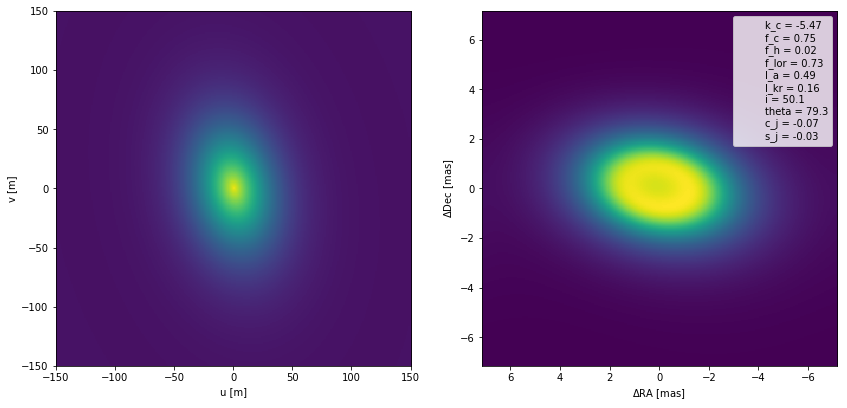

Chi2 MCMC 3a, median (full): 5.490895320907648
Reduced Chi2 MCMC 3a, median (full): 0.1372723830226912
Chi2 MCMC 3a, median (VIS2): 3.9795134716631493
Reduced Chi2 MCMC 3a, median (VIS2): 0.19897567358315746
Chi2 MCMC 3a, median (CPs): 1.5113818492444997
Reduced Chi2 MCMC 3a, median (CPs): 0.15113818492444997


In [62]:
    ##################################
    # 3a) MCMC 3a)
    ##################################

    # ---- load previous parameters
    corr_factors_chi2 = np.loadtxt(os.path.join(path_working_place, t, fit_mode,
                                                f'correction_factors_chi2_{fit_mode}.dat'))
    corr_factor_a_vis2 = corr_factors_chi2[0, 0]
    corr_factor_a_cp = corr_factors_chi2[0, 1]
    corr_factor_b_vis2 = corr_factors_chi2[1, 0]
    corr_factor_b_cp = corr_factors_chi2[1, 1]

    file_sce_2a = open(
        os.path.join(path_working_place, t, fit_mode, f'results_sce_2a_{fit_mode}.dat'),
        "r")
    results_sce_2a = json.loads(file_sce_2a.read())
    file_sce_2a.close()

    file_sce_2b = open(
        os.path.join(path_working_place, t, fit_mode, f'results_sce_2b_{fit_mode}.dat'),
        "r")
    results_sce_2b = json.loads(file_sce_2b.read())
    file_sce_2b.close()

    # set initial value
    x_0_mcmc_3a = results_sce_2a['x']

    pos = x_0_mcmc_3a + 1e-4 * np.random.randn(nwalkers, ndim)

    # Test if hdf5 file exists and do not rerun MCMC if it does
    if not os.path.exists(os.path.join(path_working_place, t, fit_mode,
                                       f"mcmc_3a_fit_{fit_mode}.hdf5")):
        backend_mcmc_3a = emcee.backends.HDFBackend(
            os.path.join(path_working_place, t, fit_mode,
                         f"mcmc_3a_fit_{fit_mode}.hdf5"))
        backend_mcmc_3a.reset(nwalkers, ndim)

        sampler_mcmc_3a = emcee.EnsembleSampler(nwalkers,
                                                ndim,
                                                log_prob,
                                                args=(func_cps,
                                                      np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                                                 cp_sc_bin[mask_cp_sc_bin].ravel()]),
                                                      np.hstack([e_vis2_sc_bin[
                                                                     mask_vis2_sc_bin].ravel() * corr_factor_a_vis2,
                                                                 e_cp_sc_bin[
                                                                     mask_cp_sc_bin].ravel() * corr_factor_a_cp]),
                                                      theta_ranges[np.invert(theta_0.mask)],
                                                      theta_0,
                                                      param_vis2,
                                                      param_cp,
                                                      f_c_0,
                                                      e_f_c_0),
                                                backend=backend_mcmc_3a)
        sampler_mcmc_3a.run_mcmc(pos, nsteps, progress=True)

    sampler_mcmc_3a = emcee.backends.HDFBackend(
        os.path.join(path_working_place, t, fit_mode, f"mcmc_3a_fit_{fit_mode}.hdf5"))
    # print(f'Auto correlation times: {sampler.get_autocorr_time()}')
    flat_samples_mcmc_3a = sampler_mcmc_3a.get_chain(discard=int(nsteps / 50 * 10), thin=int(nsteps / 50 / 5),
                                                     flat=True)

    # shift PA to [0, pi/2]
    index_pa = np.where(theta_ranges[np.invert(theta_0.mask)] == (-2. * np.pi, 2 * np.pi))[0][0]

    tmp_pa_in_mcmc_3a = np.rad2deg(flat_samples_mcmc_3a.T[index_pa,])
    tmp_pa_in_hist_mcmc_3a, tmp_pa_in_bin_edges_mcmc_3a = np.histogram(tmp_pa_in_mcmc_3a, bins=nwalkers,
                                                                       range=(-360, 360))
    tmp_pa_in_peak = 0.5 * (tmp_pa_in_bin_edges_mcmc_3a[np.argmax(tmp_pa_in_hist_mcmc_3a) + 1] +
                            tmp_pa_in_bin_edges_mcmc_3a[np.argmax(tmp_pa_in_hist_mcmc_3a)])

    while tmp_pa_in_peak < 0:
        tmp_pa_in_peak += 180
    while tmp_pa_in_peak > 180:
        tmp_pa_in_peak -= 180
    while len(tmp_pa_in_mcmc_3a[tmp_pa_in_mcmc_3a < tmp_pa_in_peak - 90]) > 0:
        tmp_pa_in_mcmc_3a[tmp_pa_in_mcmc_3a < tmp_pa_in_peak - 90] += 180
    while len(tmp_pa_in_mcmc_3a[tmp_pa_in_mcmc_3a > tmp_pa_in_peak + 90]) > 0:
        tmp_pa_in_mcmc_3a[tmp_pa_in_mcmc_3a > tmp_pa_in_peak + 90] -= 180

    flat_samples_mcmc_3a.T[index_pa,] = np.deg2rad(tmp_pa_in_mcmc_3a)

    # calculate percentiles for parameters
    percentiles_mcmc_3a = np.array([np.percentile(i, [16, 50, 84]) for i in flat_samples_mcmc_3a.T])

    median_mcmc_3a_post_parameters = np.zeros(len(theta_0))
    tmp_count = 0
    for i, tmp_mask in enumerate(theta_0.mask):
        if not tmp_mask:
            median_mcmc_3a_post_parameters[i] = percentiles_mcmc_3a[tmp_count, 1]
            tmp_count += 1
        else:
            median_mcmc_3a_post_parameters[i] = theta_0.data[i]

    median_mcmc_3a_post_model = elliptical_ring(*median_mcmc_3a_post_parameters)

    # plot model
    median_mcmc_3a_post_model.plot_model(uu,
                                         vv,
                                         lam0_vis2[0],
                                         lam0_vis2[0],
                                         k_s_vis2[0],
                                         mode='vis2',
                                         path_save=None)

    chi2_mcmc_3a_median_full = np.sum(
        (np.hstack([np.abs(median_mcmc_3a_post_model.get_full_visibility(*param_vis2)) ** 2,
                    median_mcmc_3a_post_model.get_closure_phase(*param_cp)]) -
         np.hstack(
             [vis2_sc_bin[mask_vis2_sc_bin].ravel(), cp_sc_bin[mask_cp_sc_bin].ravel()])) ** 2 / np.hstack(
            [e_vis2_sc_bin[mask_vis2_sc_bin].ravel() * corr_factor_a_vis2,
             e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_a_cp]) ** 2)
    red_chi2_mcmc_3a_median_full = chi2_mcmc_3a_median_full / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) + len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)
    chi2_mcmc_3a_median_vis2 = np.sum((np.abs(median_mcmc_3a_post_model.get_full_visibility(*param_vis2)) ** 2 -
                                       vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2 / (e_vis2_sc_bin[
                                                                                          mask_vis2_sc_bin].ravel() * corr_factor_a_vis2) ** 2)
    red_chi2_mcmc_3a_median_vis2 = chi2_mcmc_3a_median_vis2 / (
                len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) - ndim)
    chi2_mcmc_3a_median_cps = np.sum((median_mcmc_3a_post_model.get_closure_phase(*param_cp) -
                                      cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2 / (
                                                 e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_a_cp) ** 2)
    red_chi2_mcmc_3a_median_cps = chi2_mcmc_3a_median_cps / (len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)

    print(f'Chi2 MCMC 3a, median (full): {chi2_mcmc_3a_median_full}')
    print(f'Reduced Chi2 MCMC 3a, median (full): {red_chi2_mcmc_3a_median_full}')
    print(f'Chi2 MCMC 3a, median (VIS2): {chi2_mcmc_3a_median_vis2}')
    print(f'Reduced Chi2 MCMC 3a, median (VIS2): {red_chi2_mcmc_3a_median_vis2}')
    print(f'Chi2 MCMC 3a, median (CPs): {chi2_mcmc_3a_median_cps}')
    print(f'Reduced Chi2 MCMC 3a, median (CPs): {red_chi2_mcmc_3a_median_cps}')

    # ---- save results
    results_mcmc_3a = {
        'x': list(percentiles_mcmc_3a[:, 1]),
        'sol': list(median_mcmc_3a_post_parameters),
        'chi2_full': chi2_mcmc_3a_median_full,
        'chi2_vis2': chi2_mcmc_3a_median_vis2,
        'chi2_cps': chi2_mcmc_3a_median_cps,
        'red_chi2_full': red_chi2_mcmc_3a_median_full,
        'red_chi2_vis2': red_chi2_mcmc_3a_median_vis2,
        'red_chi2_cps': red_chi2_mcmc_3a_median_cps,
    }

    file_mcmc_3a = open(os.path.join(path_working_place, t, fit_mode,
                                     f'results_mcmc_3a_{fit_mode}.dat'), "w")
    json.dump(results_mcmc_3a, file_mcmc_3a)
    file_mcmc_3a.close()

Quantiles:
[(0.16, -5.845372737692476), (0.5, -5.474037614761208), (0.84, -4.855071092427018)]
Quantiles:
[(0.16, 0.7484139162519508), (0.5, 0.7538191104315057), (0.84, 0.759101118152179)]
Quantiles:
[(0.16, 0.007735363549565689), (0.5, 0.019453578985335993), (0.84, 0.031679878117552004)]
Quantiles:
[(0.16, 0.514798951958297), (0.5, 0.7299855619320201), (0.84, 0.9142668540712633)]
Quantiles:
[(0.16, 0.4654759395383569), (0.5, 0.48915834173546074), (0.84, 0.517550578778639)]
Quantiles:
[(0.16, 0.030797307433600877), (0.5, 0.1635424722095441), (0.84, 1.8176731981017789)]
Quantiles:
[(0.16, 0.5581831304892826), (0.5, 0.6412003325179989), (0.84, 0.7167796069023029)]
Quantiles:
[(0.16, 1.3465518044807223), (0.5, 1.3846557067505294), (0.84, 1.434603911225493)]
Quantiles:
[(0.16, -0.128377360075593), (0.5, -0.0687260865358334), (0.84, -0.011625918267715005)]
Quantiles:
[(0.16, -0.07753850913453898), (0.5, -0.03471191528453341), (0.84, 0.005824678113117668)]


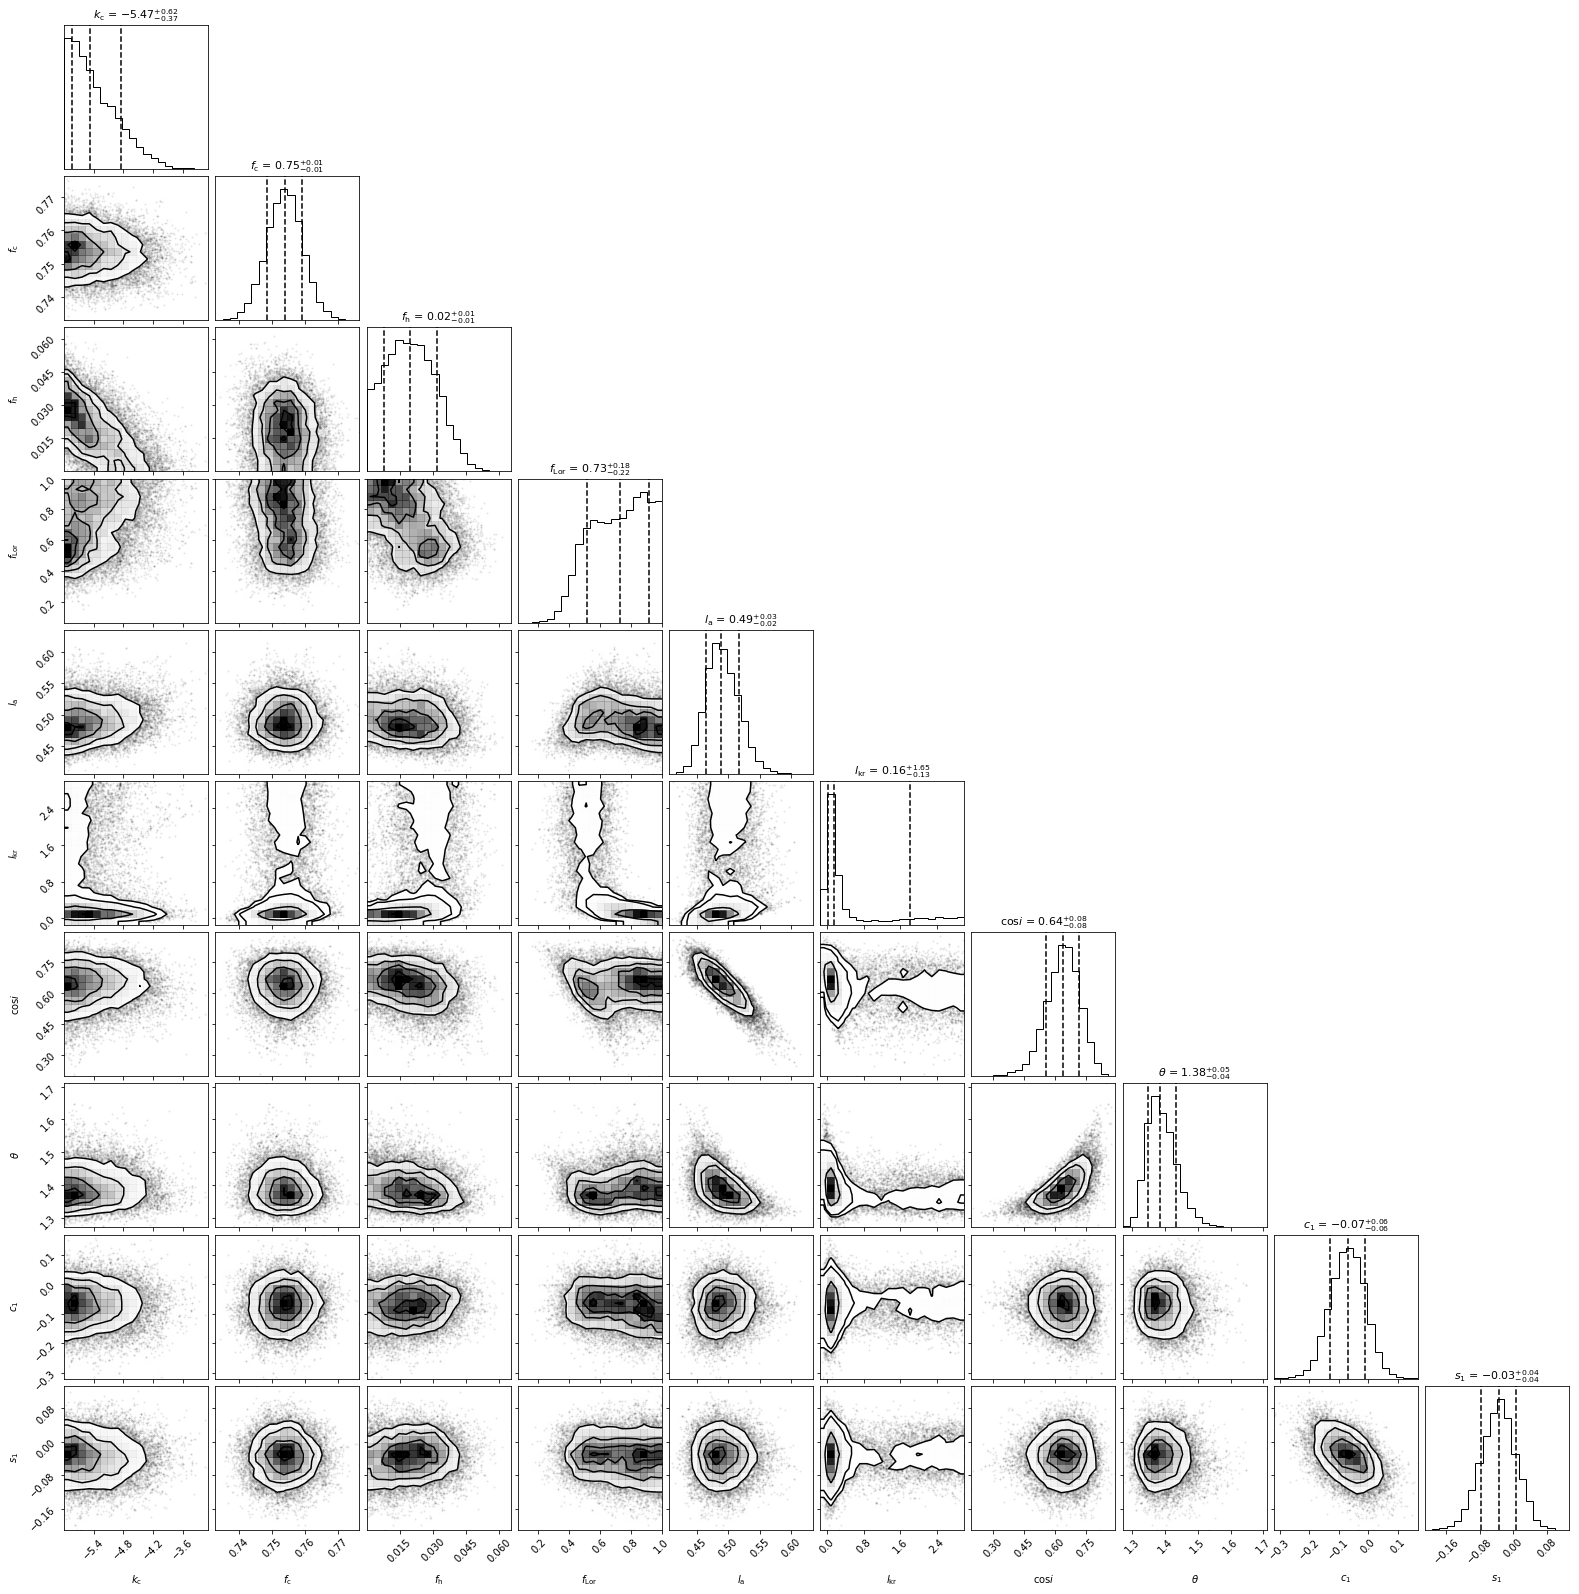

In [63]:
    # ---- Plotting
    # --- 1) Walkers
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler_mcmc_3a.get_chain()
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.01)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[np.invert(theta_0.mask)][i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()
    plt.close(fig)

    # --- 2) Correlations / corner plot
    fig = corner.corner(data=flat_samples_mcmc_3a,
                        color='k',
                        labels=labels[np.invert(theta_0.mask)],
                        show_titles=True,
                        truth_color='C0',
                        title_kwargs={"fontsize": 11},
                        quantiles=[.16, .50, .84],
                        verbose=True)

    plt.show()
    plt.close(fig)

100%|██████████| 2000/2000 [03:22<00:00,  8.32it/s]


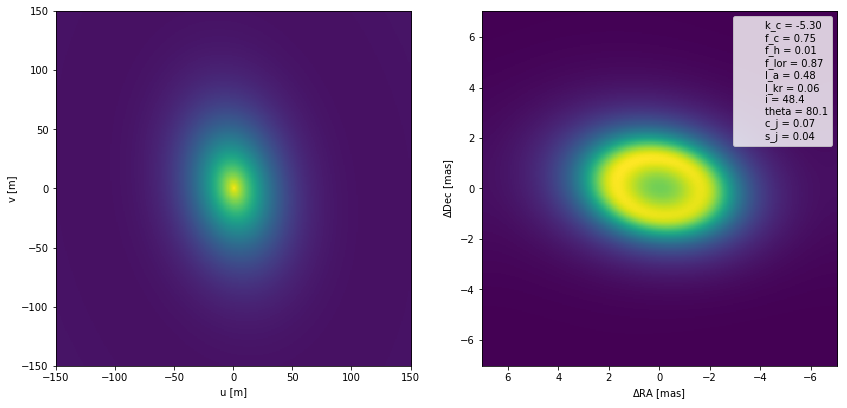

Chi2 MCMC 3b, median (full): 132.70813228997565
Reduced Chi2 MCMC 3b, median (full): 3.317703307249391
Chi2 MCMC 3b, median (VIS2): 2.0336061033407034
Reduced Chi2 MCMC 3b, median (VIS2): 0.10168030516703516
Chi2 MCMC 3b, median (CPs): 130.67452618663495
Reduced Chi2 MCMC 3b, median (CPs): 13.067452618663495


In [64]:
    ##################################
    # 3b) MCMC 3b)
    ##################################

    # set initial value
    x_0_mcmc_3b = results_sce_2b['x']

    pos = x_0_mcmc_3b + 1e-4 * np.random.randn(nwalkers, ndim)

    # Test if hdf5 file exists and do not rerun MCMC if it does
    if not os.path.exists(os.path.join(path_working_place, t, fit_mode,
                                       f"mcmc_3b_fit_{fit_mode}.hdf5")):
        backend_mcmc_3b = emcee.backends.HDFBackend(
            os.path.join(path_working_place, t, fit_mode,
                         f"mcmc_3b_fit_{fit_mode}.hdf5"))
        backend_mcmc_3b.reset(nwalkers, ndim)

        sampler_mcmc_3b = emcee.EnsembleSampler(nwalkers,
                                                ndim,
                                                log_prob,
                                                args=(func_cps,
                                                      np.hstack([vis2_sc_bin[mask_vis2_sc_bin].ravel(),
                                                                 cp_sc_bin[mask_cp_sc_bin].ravel()]),
                                                      np.hstack([e_vis2_sc_bin[
                                                                     mask_vis2_sc_bin].ravel() * corr_factor_b_vis2,
                                                                 e_cp_sc_bin[
                                                                     mask_cp_sc_bin].ravel() * corr_factor_b_cp]),
                                                      theta_ranges[np.invert(theta_0.mask)],
                                                      theta_0,
                                                      param_vis2,
                                                      param_cp,
                                                      f_c_0,
                                                      e_f_c_0),
                                                backend=backend_mcmc_3b)
        sampler_mcmc_3b.run_mcmc(pos, nsteps, progress=True)

    sampler_mcmc_3b = emcee.backends.HDFBackend(
        os.path.join(path_working_place, t, fit_mode, f"mcmc_3b_fit_{fit_mode}.hdf5"))
    # print(f'Auto correlation times: {sampler.get_autocorr_time()}')
    flat_samples_mcmc_3b = sampler_mcmc_3b.get_chain(discard=int(nsteps / 50 * 5), thin=int(nsteps / 50 / 5),
                                                     flat=True)

    # shift PA to [0, pi/2]
    tmp_pa_in_mcmc_3b = np.rad2deg(flat_samples_mcmc_3b.T[index_pa,])
    tmp_pa_in_hist_mcmc_3b, tmp_pa_in_bin_edges_mcmc_3b = np.histogram(tmp_pa_in_mcmc_3b, bins=nwalkers,
                                                                       range=(-360, 360))
    tmp_pa_in_peak = 0.5 * (tmp_pa_in_bin_edges_mcmc_3b[np.argmax(tmp_pa_in_hist_mcmc_3b) + 1] +
                            tmp_pa_in_bin_edges_mcmc_3b[np.argmax(tmp_pa_in_hist_mcmc_3b)])

    while tmp_pa_in_peak < 0:
        tmp_pa_in_peak += 180
    while tmp_pa_in_peak > 180:
        tmp_pa_in_peak -= 180
    while len(tmp_pa_in_mcmc_3b[tmp_pa_in_mcmc_3b < tmp_pa_in_peak - 90]) > 0:
        tmp_pa_in_mcmc_3b[tmp_pa_in_mcmc_3b < tmp_pa_in_peak - 90] += 180
    while len(tmp_pa_in_mcmc_3b[tmp_pa_in_mcmc_3b > tmp_pa_in_peak + 90]) > 0:
        tmp_pa_in_mcmc_3b[tmp_pa_in_mcmc_3b > tmp_pa_in_peak + 90] -= 180

    flat_samples_mcmc_3b.T[index_pa,] = np.deg2rad(tmp_pa_in_mcmc_3b)

    # calculate percentiles for parameters
    percentiles_mcmc_3b = np.array([np.percentile(i, [16, 50, 84]) for i in flat_samples_mcmc_3b.T])

    median_mcmc_3b_post_parameters = np.zeros(len(theta_0))
    tmp_count = 0
    for i, tmp_mask in enumerate(theta_0.mask):
        if not tmp_mask:
            median_mcmc_3b_post_parameters[i] = percentiles_mcmc_3b[tmp_count, 1]
            tmp_count += 1
        else:
            median_mcmc_3b_post_parameters[i] = theta_0.data[i]

    median_mcmc_3b_post_model = elliptical_ring(*median_mcmc_3b_post_parameters)
    # median_mcmc_3b_post_model = elliptical_ring(*[-0.08, 0.12, 0.07, 0.41, 0.23, -2.14, np.cos(np.deg2rad(35.3)), np.deg2rad(316.8), -0.04, 0.02])

    # plot model
    median_mcmc_3b_post_model.plot_model(uu,
                                         vv,
                                         lam0_vis2[0],
                                         lam0_vis2[0],
                                         k_s_vis2[0],
                                         mode='vis2',
                                         path_save=None)

    chi2_mcmc_3b_median_full = np.sum(
        (np.hstack([np.abs(median_mcmc_3b_post_model.get_full_visibility(*param_vis2)) ** 2,
                    median_mcmc_3b_post_model.get_closure_phase(*param_cp)]) -
         np.hstack(
             [vis2_sc_bin[mask_vis2_sc_bin].ravel(), cp_sc_bin[mask_cp_sc_bin].ravel()])) ** 2 / np.hstack(
            [e_vis2_sc_bin[mask_vis2_sc_bin].ravel() * corr_factor_b_vis2,
             e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_b_cp]) ** 2)
    red_chi2_mcmc_3b_median_full = chi2_mcmc_3b_median_full / (
            len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) + len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)
    chi2_mcmc_3b_median_vis2 = np.sum((np.abs(median_mcmc_3b_post_model.get_full_visibility(*param_vis2)) ** 2 -
                                       vis2_sc_bin[mask_vis2_sc_bin].ravel()) ** 2 / (e_vis2_sc_bin[
                                                                                          mask_vis2_sc_bin].ravel() * corr_factor_b_vis2) ** 2)
    red_chi2_mcmc_3b_median_vis2 = chi2_mcmc_3b_median_vis2 / (
                len(vis2_sc_bin[mask_vis2_sc_bin].ravel()) - ndim)
    chi2_mcmc_3b_median_cps = np.sum((median_mcmc_3b_post_model.get_closure_phase(*param_cp) -
                                      cp_sc_bin[mask_cp_sc_bin].ravel()) ** 2 / (
                                                 e_cp_sc_bin[mask_cp_sc_bin].ravel() * corr_factor_b_cp) ** 2)
    red_chi2_mcmc_3b_median_cps = chi2_mcmc_3b_median_cps / (len(cp_sc_bin[mask_cp_sc_bin].ravel()) - ndim)

    print(f'Chi2 MCMC 3b, median (full): {chi2_mcmc_3b_median_full}')
    print(f'Reduced Chi2 MCMC 3b, median (full): {red_chi2_mcmc_3b_median_full}')
    print(f'Chi2 MCMC 3b, median (VIS2): {chi2_mcmc_3b_median_vis2}')
    print(f'Reduced Chi2 MCMC 3b, median (VIS2): {red_chi2_mcmc_3b_median_vis2}')
    print(f'Chi2 MCMC 3b, median (CPs): {chi2_mcmc_3b_median_cps}')
    print(f'Reduced Chi2 MCMC 3b, median (CPs): {red_chi2_mcmc_3b_median_cps}')

    # ---- save results
    results_mcmc_3b = {
        'x': list(percentiles_mcmc_3b[:, 1]),
        'sol': list(median_mcmc_3b_post_parameters),
        'chi2_full': chi2_mcmc_3b_median_full,
        'chi2_vis2': chi2_mcmc_3b_median_vis2,
        'chi2_cps': chi2_mcmc_3b_median_cps,
        'red_chi2_full': red_chi2_mcmc_3b_median_full,
        'red_chi2_vis2': red_chi2_mcmc_3b_median_vis2,
        'red_chi2_cps': red_chi2_mcmc_3b_median_cps,
    }

    file_mcmc_3b = open(os.path.join(path_working_place, t, fit_mode,
                                     f'results_mcmc_3b_{fit_mode}.dat'), "w")
    json.dump(results_mcmc_3b, file_mcmc_3b)
    file_mcmc_3b.close()

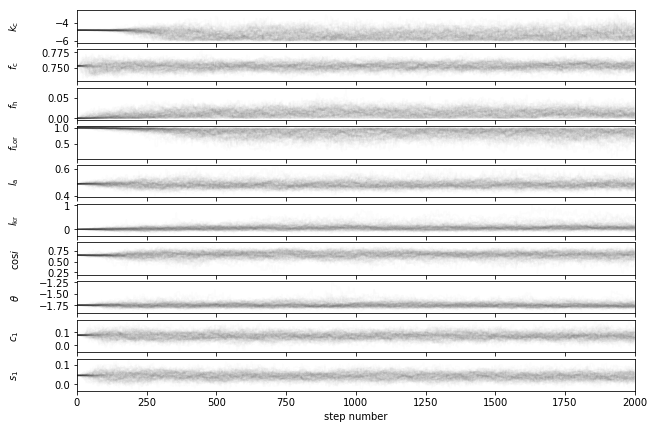

Quantiles:
[(0.16, -5.775900097571483), (0.5, -5.304952767022247), (0.84, -4.751663236564665)]
Quantiles:
[(0.16, 0.747432079465635), (0.5, 0.7528780260914536), (0.84, 0.7581822307975401)]
Quantiles:
[(0.16, 0.004348204801501433), (0.5, 0.013111424028993436), (0.84, 0.02356273779509805)]
Quantiles:
[(0.16, 0.7168878461443335), (0.5, 0.8721872351194946), (0.84, 0.9657140095404998)]
Quantiles:
[(0.16, 0.4601647333677492), (0.5, 0.4817980264634151), (0.84, 0.5081727293328293)]
Quantiles:
[(0.16, -0.009891029278655858), (0.5, 0.06477551774902805), (0.84, 0.162698805424264)]
Quantiles:
[(0.16, 0.5853575685147229), (0.5, 0.663616189669687), (0.84, 0.730919211086969)]
Quantiles:
[(0.16, 1.3576762403487093), (0.5, 1.397329372006213), (0.84, 1.4500967783966154)]
Quantiles:
[(0.16, 0.046681516530563294), (0.5, 0.07091361006700331), (0.84, 0.09608235640802539)]
Quantiles:
[(0.16, 0.024599623585217324), (0.5, 0.0421304457469277), (0.84, 0.05980053610821062)]


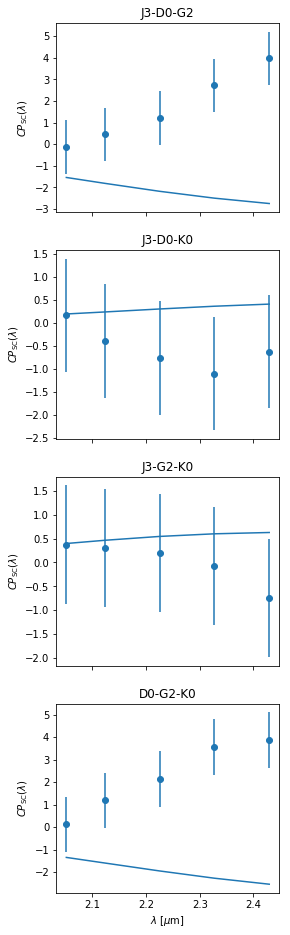

In [65]:
    # ---- Plotting
    # --- 1) Walkers
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler_mcmc_3b.get_chain()
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.01)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[np.invert(theta_0.mask)][i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()
    plt.close(fig)

    # --- 2) Correlations / corner plot
    fig = corner.corner(data=flat_samples_mcmc_3b,
                        color='k',
                        labels=labels[np.invert(theta_0.mask)],
                        show_titles=True,
                        truth_color='C0',  # edited in source code so that this is the color of the quantiles
                        title_kwargs={"fontsize": 11},
                        # range=[(990, 1490), (3.49,3.57), (0.5, 2.5), (-4.82, -4.52)],
                        quantiles=[.16, .50, .84],
                        verbose=True)

    plt.show()
    plt.close(fig)

    # --- 3) plot fitted visibilities
    vis2_sc_best_fit_mcmc_3b, cp_sc_best_fit_mcmc_3b = np.split(
        ary=func_cps(percentiles_mcmc_3b[:, 1], theta_0, param_vis2, param_cp),
        indices_or_sections=[len(vis2_sc_bin[mask_vis2_sc_bin].ravel())])
    # vis2_sc_best_fit_mcmc_3b, cp_sc_best_fit_mcmc_3b = np.split(ary=func_cps([-0.08, 0.12, 0.07, 0.41, 0.23, -2.14, np.cos(np.deg2rad(35.3)), np.deg2rad(316.8), -0.04, 0.02], theta_0, param_vis2, param_cp),
    #                                                             indices_or_sections=[len(vis2_sc_bin.ravel())])

    f, ax = plt.subplots(nrows=n_baselines, ncols=1, figsize=(4, 16), sharex=True)
    for i, (tmp_u, tmp_v) in enumerate(zip(u_coord_sc_avg_exp, v_coord_sc_avg_exp)):
        ax[i % n_baselines].errorbar(wavelengths_sc_vis2_bin[i, mask_vis2_sc_bin[i,]] * 1e6,
                                     vis2_sc_bin[i, mask_vis2_sc_bin[i,]],
                                     yerr=e_vis2_sc_bin[i, mask_vis2_sc_bin[i,]] * corr_factor_b_vis2,
                                     linestyle='none',
                                     marker='o',
                                     color=f'C{np.floor(i / 6):.0f}')
        ax[i % n_baselines].plot(wavelengths_sc_vis2_bin[i, mask_vis2_sc_bin[i,]] * 1e6,
                                 vis2_sc_best_fit_mcmc_3b[
                                 len(mask_vis2_sc_bin[:i, ][mask_vis2_sc_bin[:i, ]]):len(
                                     mask_vis2_sc_bin[:i, ][mask_vis2_sc_bin[:i, ]]) + len(
                                     mask_vis2_sc_bin[i,][mask_vis2_sc_bin[i,]])],
                                 color=f'C{np.floor(i / 6):.0f}'
                                 )
        # ax[i%6].plot([], [], linestyle='none')
        if i < n_baselines:
            # ax[i].set_ylim(0, 1)
            ax[i].set_ylabel(r'$|V|^2$')
            # ax[i].legend(loc=0)
            ax[i].set_title(f'{index_to_ut[baselines_sc[i, 0]]}-{index_to_ut[baselines_sc[i, 1]]}')
    ax[-1].set_xlabel(r'$\lambda$ [$\mu$m]')
    plt.show()
    plt.close(f)

    # --- 4) plot fitted CPs
    f, ax = plt.subplots(nrows=n_triplets, ncols=1, figsize=(4, 16), sharex=True)
    for i, (tmp_u_1, tmp_u_2, tmp_v_1, tmp_v_2) in enumerate(
            zip(u1_coord_sc_avg_exp, u2_coord_sc_avg_exp, v1_coord_sc_avg_exp, v2_coord_sc_avg_exp)):
        ax[i % n_triplets].errorbar(wavelengths_sc_cp_bin[i, mask_cp_sc_bin[i,]] * 1e6,
                                    cp_sc_bin[i, mask_cp_sc_bin[i,]],
                                    yerr=e_cp_sc_bin[i, mask_cp_sc_bin[i,]] * corr_factor_b_cp,
                                    linestyle='none',
                                    marker='o',
                                    color=f'C{np.floor(i / 4):.0f}')
        ax[i % n_triplets].plot(wavelengths_sc_cp_bin[i, mask_cp_sc_bin[i,]] * 1e6,
                                cp_sc_best_fit_mcmc_3b[len(mask_cp_sc_bin[:i, ][mask_cp_sc_bin[:i, ]]):len(
                                    mask_cp_sc_bin[:i, ][mask_cp_sc_bin[:i, ]]) + len(
                                    mask_cp_sc_bin[i,][mask_cp_sc_bin[i,]])],
                                color=f'C{np.floor(i / 4):.0f}'
                                )
        # ax[i%4].plot([], [], linestyle='none')
        if i < n_triplets:
            # ax[i].set_ylim(-10, 10)
            ax[i].set_ylabel(r'$CP_\mathrm{SC}(\lambda)$')
            # ax[i].legend(loc=0)
            ax[i].set_title(
                f'{index_to_ut[triplets_sc[i, 0]]}-{index_to_ut[triplets_sc[i, 1]]}-{index_to_ut[triplets_sc[i, 2]]}')
    ax[-1].set_xlabel(r'$\lambda$ [$\mu$m]')
    plt.show()
    plt.close(f)